# Omnigot and Person Re-ID

In [3]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import cv2
from scipy.spatial import distance

In [4]:
import vbranch as vb
from vbranch.applications.resnet import ResNet18
from vbranch.utils.training_utils import wrap_iterator
from vbranch.utils.test_utils import get_run, compute_one_shot_acc, baseline_one_shot
from vbranch.losses import triplet

In [ ]:
model_id = 1
architecture = 'res'

## Load Data

In [4]:
dataset = 'market'

if dataset == 'omniglot':
    A, P, K = 4, 8, 4
    train_generator = vb.datasets.omniglot.load_generator('train')
    test_generator = vb.datasets.omniglot.load_generator('test')
elif dataset == 'market':
    P, K = 18, 4
    train_generator = vb.datasets.reid.TripletDataGenerator(dataset, 'train')

In [5]:
batch = train_generator.next(4, 4, flatten=False, preprocess=False)

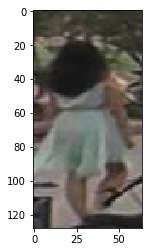

In [6]:
plt.imshow(batch[0, 0].squeeze(), cmap=plt.cm.gray)
plt.show()

In [7]:
batch.min(), batch.max()

(0, 255)

## Build Model

In [8]:
EPOCHS = 50
T_0 = 30
STEPS_PER_EPOCH = 100
output_dim = 128
input_dim = (None,) + batch.shape[-3:]
print(input_dim)

(None, 128, 64, 3)


In [9]:
if not os.path.isdir('models'):
    os.system('mkdir models')
    
model_path = 'models/{}-{}_{}'.format(dataset, architecture, model_id)
print(model_path)

models/market-res_1


In [10]:
tf.reset_default_graph()

train_dataset = tf.data.Dataset.from_generator(wrap_iterator(train_generator, P, K), 
                                               'float32', output_shapes=input_dim)

# Dataset for feeding non-triplet batched images from memory
x = tf.placeholder('float32', input_dim, name='x')
batch_size = tf.placeholder('int64', name='batch_size')
test_dataset = tf.data.Dataset.from_tensor_slices(x).batch(batch_size)

iter_ = tf.data.Iterator.from_structure('float32', input_dim)
train_init_op = iter_.make_initializer(train_dataset)
test_init_op = iter_.make_initializer(test_dataset, name='test_init_op')

inputs = iter_.get_next()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.


In [11]:
if architecture == 'simple':
    model = vb.simple_cnn(inputs, output_dim, 32, 64, 128, 256, 
                          name='model_' + str(model_id))
elif architecture == 'res':
#     model = vb.resnet(inputs, output_dim, 16, 32, 64, 
#                       name='model_' + str(model_id))
    model = ResNet18(inputs, output_dim, name='model_' + str(model_id))

In [12]:
model.summary()

i   Layer name                      Output shape     Parameters           Num param  Inbound             
---------------------------------------------------------------------------------------------------------
    Input                           [None,128,64,3]                                                      
---------------------------------------------------------------------------------------------------------
0   pre_conv (Conv2D)               [None,64,32,64]  [7,7,3,64] [64]      9472       IteratorGetNext:0   
---------------------------------------------------------------------------------------------------------
1   pre_bn (BatchNormalization)     [None,64,32,64]  [64] [64]            128        pre_conv            
---------------------------------------------------------------------------------------------------------
2   pre_relu (Activation)           [None,64,32,64]                       0          pre_bn              
----------------------------------------------

In [13]:
def lr_exp_decay_scheduler(init_lr, t0, t1, decay):
    """NOTE: `episode` starts from 1"""
    def func(episode):
        if episode < t0:
            return init_lr
        lr = init_lr * np.power(decay, (episode - t0) / (t1 - t0))
        return lr
    return func

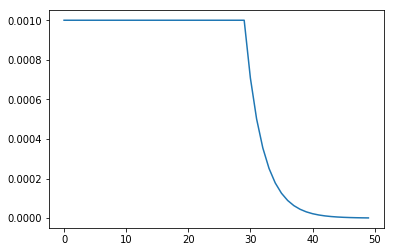

In [14]:
lr_scheduler = lr_exp_decay_scheduler(0.001, t0=T_0, t1=EPOCHS, decay=0.001)
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)
plt.show()

In [15]:
lr = tf.placeholder('float32', name='lr')
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

model.compile(optimizer, triplet(model.output, P=P, K=K))

Custom loss used...
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [16]:
print(model.output)

Tensor("output/output:0", shape=(?, 128), dtype=float32)


In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for e in range(EPOCHS):
        print("Epoch {}/{}".format(e + 1, EPOCHS))
        progbar = tf.keras.utils.Progbar(STEPS_PER_EPOCH)

        sess.run(train_init_op)
        learning_rate = lr_scheduler(e + 1)
                
        for i in range(STEPS_PER_EPOCH):
            _, loss_value = sess.run([model.train_op, model.loss], 
                                     feed_dict={lr:learning_rate})
            
            if dataset == 'omniglot' and i == STEPS_PER_EPOCH - 1:
                acc = baseline_one_shot(sess)
                values=[('loss', loss_value), ('acc', acc), ('lr', learning_rate)]
            else:
                values=[('loss', loss_value), ('lr', learning_rate)]
            
            progbar.update(i + 1, values=values)
    
    saver = tf.train.Saver()
    path = os.path.join(model_path, 'ckpt')
    saver.save(sess, path)

Epoch 1/50
100/100 [==============================] - 19s 194ms/step - loss: 598.4783 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 10s 95ms/step - loss: 144.1848 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 10s 98ms/step - loss: 142.1710 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 9s 94ms/step - loss: 133.6465 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 9s 93ms/step - loss: 109.2266 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 9s 89ms/step - loss: 142.8146 - lr: 0.0010
Epoch 7/50
100/100 [==============================] - 9s 93ms/step - loss: 137.6108 - lr: 0.0010
Epoch 8/50
100/100 [==============================] - 9s 93ms/step - loss: 138.9665 - lr: 0.0010
Epoch 9/50
100/100 [==============================] - 9s 91ms/step - loss: 132.2407 - lr: 0.0010
Epoch 10/50
100/100 [==============================] - 9s 90ms/step - loss: 110.0667 - lr: 0.0010
Epoch 11/50
100/100 [====

## Model Ensemble

In [8]:
def restore_sess(sess, model_path):
    meta_path = os.path.join(model_path, 'ckpt.meta')
    ckpt = tf.train.get_checkpoint_state(model_path)

    imported_graph = tf.train.import_meta_graph(meta_path)
    imported_graph.restore(sess, ckpt.model_checkpoint_path)

In [12]:
total_runs = 20
run_data = [get_run(r+1) for r in range(total_runs)]

model_train_runs = []
model_test_runs = []

for i in [0]:
    train_runs = []
    test_runs = []

    graph = tf.Graph()
    sess = tf.Session(graph=graph)

    with sess.as_default(), graph.as_default():
        restore_sess(sess, model_path)

        for r in range(total_runs):
            train_files,test_files,train_ims,test_ims,answers_files = \
                run_data[r]

            feed_dict = {'x:0':train_ims,'batch_size:0':len(train_ims)}
            sess.run('test_init_op', feed_dict=feed_dict)
            train_runs.append(sess.run('model_%d'%(i+1)+'/'+'output:0'))

            feed_dict = {'x:0':test_ims, 'batch_size:0':len(test_ims)}
            sess.run('test_init_op', feed_dict=feed_dict)
            test_runs.append(sess.run('model_%d'%(i+1)+'/'+'output:0'))

    model_train_runs.append(train_runs)
    model_test_runs.append(test_runs)

INFO:tensorflow:Restoring parameters from ./models/omniglot-simple_1/ckpt


### Average Embedding

In [13]:
mean_acc_runs = []

test_embed = np.mean(model_test_runs, axis=0)
train_embed = np.mean(model_train_runs, axis=0)

for r in range(total_runs):
    train_files = run_data[r][0]
    answers_files = run_data[r][-1]

    acc = compute_one_shot_acc(test_embed[r], train_embed[r],train_files,answers_files)
    mean_acc_runs.append(acc)

In [14]:
print(mean_acc_runs)
print(np.mean(mean_acc_runs))

[0.6, 0.4, 0.5, 0.7, 0.75, 0.65, 0.3, 0.65, 0.35, 0.5, 0.85, 0.6, 0.35, 0.55, 0.95, 0.85, 0.7, 0.5, 0.4, 0.6]
0.5875


### Concatenate Embedding

In [15]:
concat_acc_runs = []

test_embed = np.concatenate(model_test_runs, axis=-1)
train_embed = np.concatenate(model_train_runs, axis=-1)

for r in range(total_runs):
    train_files = run_data[r][0]
    answers_files = run_data[r][-1]
    
    acc = compute_one_shot_acc(test_embed[r], train_embed[r],train_files, answers_files)
    concat_acc_runs.append(acc)

In [16]:
test_embed.shape

(20, 20, 128)

In [17]:
print(concat_acc_runs)
print(np.mean(concat_acc_runs))

[0.6, 0.4, 0.5, 0.7, 0.75, 0.65, 0.3, 0.65, 0.35, 0.5, 0.85, 0.6, 0.35, 0.55, 0.95, 0.85, 0.7, 0.5, 0.4, 0.6]
0.5875
